In [3]:
import math
import torch
import torch.nn as nn
import numpy 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
def get_dims(c,h,w,k,s,p):
    
    new_h = math.floor(((h+2*p-1*(k-1)-1)/s)+1)
    new_w = math.floor(((w+2*p-1*(k-1)-1)/s)+1)
    print(new_h,new_w)
get_dims(3,28,28,3,2,1)
get_dims(3,14,14,3,2,1)
#get_dims(3,256,256,3,1,1)

14 14
7 7


In [5]:
def get_transposed_conv_dims(h, w, k, s, p, o):
    new_h = (h - 1) * s - 2 * p + k + o
    new_w = (w - 1) * s - 2 * p + k + o
    print(new_h,new_w)
get_transposed_conv_dims(7,7,3,2,1,1)
get_transposed_conv_dims(14,14,3,2,1,1)

14 14
28 28


In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
            ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
                   ])),
    batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 9.09MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 244kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.62MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.54MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim = 2):
        super().__init__()

        self.latent_dim = latent_dim

        
        #The encoder serves as q(z|x)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride = 2, padding = 1), #bx1x28x28 -> bx32x14x14
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(),
                                     
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding = 1), #bx32x14x14 -> bx64x7x7
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),


                                     #flatten before applying reparametrization trick
                                     nn.Flatten(start_dim=1) #bx64x7x7 -> bx128*7*7
                                    )
        
        self.mu = nn.Linear(64*7*7, latent_dim)
        self.log_var = nn.Linear(64*7*7, latent_dim)

        self.project_up = nn.Sequential(nn.Linear(2, 64*7*7),
                                        nn.BatchNorm1d(64*7*7),
                                        nn.ReLU()
                                       )
        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1), #bx128x7x7 -> bx64x14x14
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),

                                    nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), #bx64x14x14 -> bx32x28x28
                                    nn.Sigmoid()
                                    )

        
    def encode(self, x):
        h = self.encoder(x) #compute hidden state
        mu = self.mu(h) #feed h into variable mu
        log_var = self.log_var(h) #feed h into variable log_var
        return mu, log_var
        
    def reparameterization(self, mu, log_var):
        epsilon = torch.randn_like(mu) #creating same shape as mu but drawn from unit gaussian
        sigma = torch.exp(0.5*log_var)
        z = mu+sigma*epsilon
        return z

    def decode(self, z):
        z_projected = self.project_up(z).reshape(-1,64,7,7)
        x_reconstructed = self.decoder(z_projected)
        return x_reconstructed
    
        
    def forward(self,x):

        mu, log_var = self.encode(x)
        
        z = self.reparameterization(mu, log_var)


        x_reconstructed = self.decode(z)


        return x_reconstructed, mu, log_var
            

        

In [9]:
def kl_divergence(mu, log_var):
    pre_batch_average = 0.5*((torch.exp(log_var)+mu**2-1-log_var).sum(dim=1)) #summing over latent dimension
    return pre_batch_average.mean()

In [10]:
device = torch.device("cuda")
def train_epoch(model, device, optimizer, loss_function, lr, dataloader):
    acc_loss = 0 
    total_samples = 1
    model.train()


    for (image_batch,_) in dataloader:
            image_batch = image_batch.to(device)
            
            prediction_batch, mu, log_var = model(image_batch)
            reconstruction_loss = loss_function(prediction_batch, image_batch)
            min_elbo_loss = reconstruction_loss + 0.001*kl_divergence(mu, log_var)

            # print("reconstruction_loss",reconstruction_loss)
            # print("kl_div",kl_divergence(mu, log_var), 0.001*kl_divergence(mu, log_var))
            # print("elbo", min_elbo_loss,"\n")

            acc_loss +=min_elbo_loss.item()*len(image_batch)
            total_samples += len(image_batch)
        
            optimizer.zero_grad()
            min_elbo_loss.backward()
            optimizer.step()

    
    return acc_loss/total_samples

def val_epoch(model, device, loss_function, lr, dataloader):
    acc_loss = 0
    total_samples = 1     
    model.eval()
    with torch.no_grad():
        for (image_batch,_) in dataloader:
            image_batch = image_batch.to(device)
            
            prediction_batch, mu, log_var = model(image_batch)
            
            reconstruction_loss = loss_function(prediction_batch, image_batch)
            min_elbo_loss = reconstruction_loss + kl_divergence(mu, log_var)
            acc_loss +=min_elbo_loss.item()*len(image_batch)
            total_samples += len(image_batch)
            
    return acc_loss/total_samples
def train_model(model, device, loss_function, lr, epochs, train_dataloader, val_dataloader):
    
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    loss_list = []
    for e in tqdm(range(epochs)):
        
        
        train_epoch_loss = train_epoch(model, device, optimizer, loss_function, lr, train_dataloader)
        val_epoch_loss = val_epoch(model, device, loss_function, lr, val_dataloader)
        print(train_epoch_loss, val_epoch_loss)
        
        loss_list.append((train_epoch_loss,val_epoch_loss))
    return model, loss_list
 

model, loss_list = train_model(VAE(2).to(device),device, nn.MSELoss(reduction="mean").to(device), 3e-4, 50, train_loader, test_loader)

AssertionError: Torch not compiled with CUDA enabled

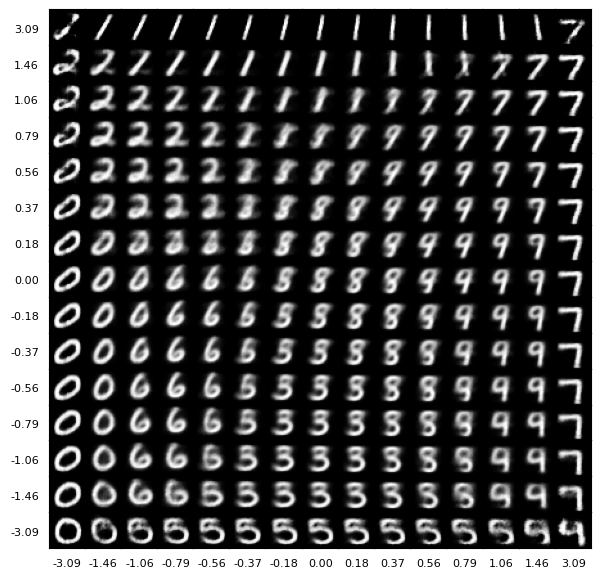

In [16]:
def visualize_prediction_distribution(model):
    model.eval()
    
    normal = torch.distributions.Normal(loc=0, scale=1)

    z_values = torch.linspace(0.001, 0.999, 15)
    z1 = normal.icdf(z_values)
    z2 = normal.icdf(z_values).sort(descending=True)[0]
    z1_grid, z2_grid = torch.meshgrid(z1,z2)
    z_pairs = torch.dstack([z1_grid,z2_grid]).transpose(0,1)
    
    fig, axes = plt.subplots(15,15, figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0)

    
    z1 = z1.numpy()
    z2 = z2.numpy()
    
    
    for i in range(len(axes)):
         for j in range(len(axes)):

            axes[i,j].imshow(model.decode(z_pairs[i,j].to(device).unsqueeze(0)).detach().cpu().squeeze(0).permute(1,2,0).numpy(), cmap="gray")
            #ax.axis("off")
    
            # Customize ticks only for outer subplots
            if i == len(axes) - 1:  # Bottom row for z1 (x-axis)
                axes[i,j].set_xticks([14])  # Place a tick in the center (arbitrary)
                axes[i,j].set_xticklabels([f"{z1[j]:.2f}"], fontsize=8)
            else:
                axes[i,j].set_xticks([])  # Remove ticks for inner subplots
            
            if j == 0:  # First column for z2 (y-axis)
                axes[i,j].set_yticks([14])  # Place a tick in the center (arbitrary)
                axes[i,j].set_yticklabels([f"{z2[i]:.2f}"], fontsize=8, rotation=0)
            else:
                axes[i,j].set_yticks([])  # Remove ticks for inner subplots
            
            # Remove axis frame to match the visual style
            axes[i,j].tick_params(left=False, bottom=False)
    
    #plt.tight_layout()
    plt.savefig("PML_assignment1_plot2_fpk297.png")
    plt.show()
    

visualize_prediction_distribution(model)

In [11]:
normal = torch.distributions.Normal(loc=0, scale=1)

z_values = torch.linspace(0.001, 0.999, 15)
z1 = normal.icdf(z_values)
z2 = normal.icdf(z_values).sort(descending=True)[0]
z1_grid, z2_grid = torch.meshgrid(z1,z2)
z_pairs = torch.dstack([z1_grid,z2_grid]).transpose(0,1)
z_pairs.shape

torch.Size([15, 15, 2])

In [12]:
z_pairs[0,14]

tensor([3.0902, 3.0902])

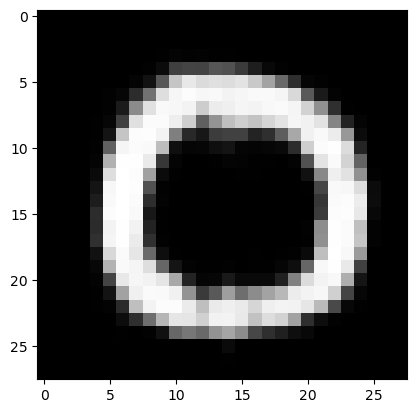

In [14]:
plt.imshow(
    model.decode(
        torch.tensor([-3.0902, -3.0902]).to(device).unsqueeze(0)
    ).detach().cpu().squeeze(0).permute(1, 2, 0).numpy(),
    cmap="gray"
)
plt.show()

In [91]:
z_pairs[1,0]

tensor([-1.4590, -3.0902])

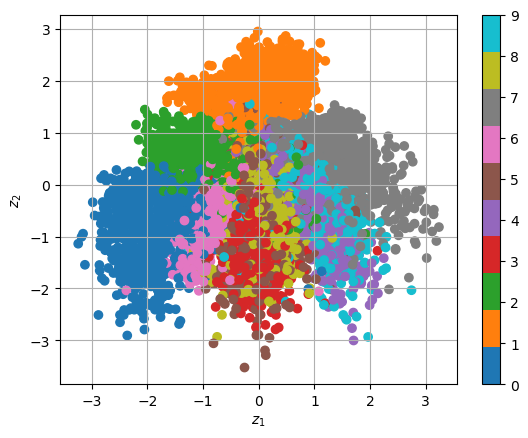

In [19]:
def plot_latent_space(model, dataloader):
    z_points = []
    label_points = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        mu, log_var = model.encode(x)
        z = model.reparameterization(mu,log_var)

        z_points.append(z)
        label_points.append(y)


    z_points = torch.cat(z_points, dim=0) 
    label_points = torch.cat(label_points, dim=0) 


    plt.scatter(z_points[:,0].detach().cpu().numpy(), z_points[:,1].detach().cpu().numpy(), c=label_points.detach().cpu().numpy(), cmap="tab10")
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    plt.grid()
    plt.colorbar()
    plt.savefig("PML_assignment1_plot1_fpk297.png")
    plt.show()
plot_latent_space(model,test_loader)